In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import scipy
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
data_raw = pd.read_csv('input/train.csv')
data_val  = pd.read_csv('input/test.csv')

data1 = data_raw.copy(deep = True)

data_cleaner = [data1, data_val]

print (data_raw.info())

data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
169,170,0,3,"Ling, Mr. Lee",male,28.00,0,0,1601,56.4958,NaN,S
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.00,3,2,347088,27.9000,NaN,S
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.00,0,0,PC 17595,28.7125,C49,C
666,667,0,2,"Butler, Mr. Reginald Fenton",male,25.00,0,0,234686,13.0000,NaN,S
560,561,0,3,"Morrow, Mr. Thomas Rowan",male,NaN,0,0,372622,7.7500,NaN,Q
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
310,311,1,1,"Hays, Miss. Margaret Bechstein",female,24.00,0,0,11767,83.1583,C54,C
712,713,1,1,"Taylor, Mr. Elmer Zebley",male,48.00,1,0,19996,52.0000,C126,S
420,421,0,3,"Gheorgheff, Mr. Stanio",male,NaN,0,0,349254,7.8958,NaN,C


In [4]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Harris, Mr. George",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
for dataset in data_cleaner:    
    # Age缺失值用中位数填充
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # Embarked缺失值用众数填充
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    # Fare缺失值用中位数填充
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
# delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column,
           axis=1,
           inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [6]:
for dataset in data_cleaner:    
    # 家庭的人数
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    
    # 是否是一个人
    dataset['IsAlone'] = 1 # initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    # 从Name中提取出称谓
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    # 对船费进行分箱
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    
    # 对年龄进行分箱
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

In [7]:
# 称谓
print(data1['Title'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Capt              1
Sir               1
Don               1
Jonkheer          1
Lady              1
the Countess      1
Mme               1
Ms                1
Name: Title, dtype: int64


In [8]:
# 将称谓中取值较少的称谓映射成Misc
stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)

data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.8+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
341,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,263.0000,S,6,0,Miss,"(31.0, 512.329]","(16.0, 32.0]"
833,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,7.8542,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
310,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,83.1583,C,1,1,Miss,"(31.0, 512.329]","(16.0, 32.0]"
521,0,3,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
591,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",female,52.0,1,0,78.2667,C,2,0,Mrs,"(31.0, 512.329]","(48.0, 64.0]"
879,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,83.1583,C,2,0,Mrs,"(31.0, 512.329]","(48.0, 64.0]"
372,0,3,"Beavan, Mr. William Thomas",male,19.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
149,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,13.0000,S,1,1,Misc,"(7.91, 14.454]","(32.0, 48.0]"
165,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,20.5250,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
117,0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,21.0000,S,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"


### 对类别变量进行LabelEncoder

In [9]:
label = LabelEncoder()
for dataset in data_cleaner:    
    # 性别
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    # 港口
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    # 称谓
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    # 年龄分箱
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    # 船费分箱
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

In [10]:
Target = ['Survived']

# 原始列名
data1_x = ['Sex','Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] # pretty name/values for charts

# Label_Encoder后的列名，没加分箱的特征
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare'] # coded for algorithm calculation

data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')

# LabelEncoder后的列名，加入了分箱的特征
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


# 对原始列名计算哑变量
data1_dummy = pd.get_dummies(data1[data1_x]) # pd.get_dummies()只会对类别变量做处理
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [11]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-" * 10)
print (data1.info())
print("-" * 10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-" * 10)
print (data_val.info())
print("-" * 10)

data_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Harris, Mr. George",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [12]:
# Label_Encoder后的列名，没加分箱的特征
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)

# LabelEncoder后的列名，加入了分箱的特征
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)

# 对原始列名计算哑变量
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Train1_x_bin Shape: {}".format(train1_x_bin.shape))
print("train1_x_dummy Shape: {}".format(train1_x_dummy.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Train1_x_bin Shape: (668, 7)
train1_x_dummy Shape: (668, 17)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [14]:
data1_x

['Sex',
 'Pclass',
 'Embarked',
 'Title',
 'SibSp',
 'Parch',
 'Age',
 'Fare',
 'FamilySize',
 'IsAlone']

In [16]:
for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-' * 10, '\n')

print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

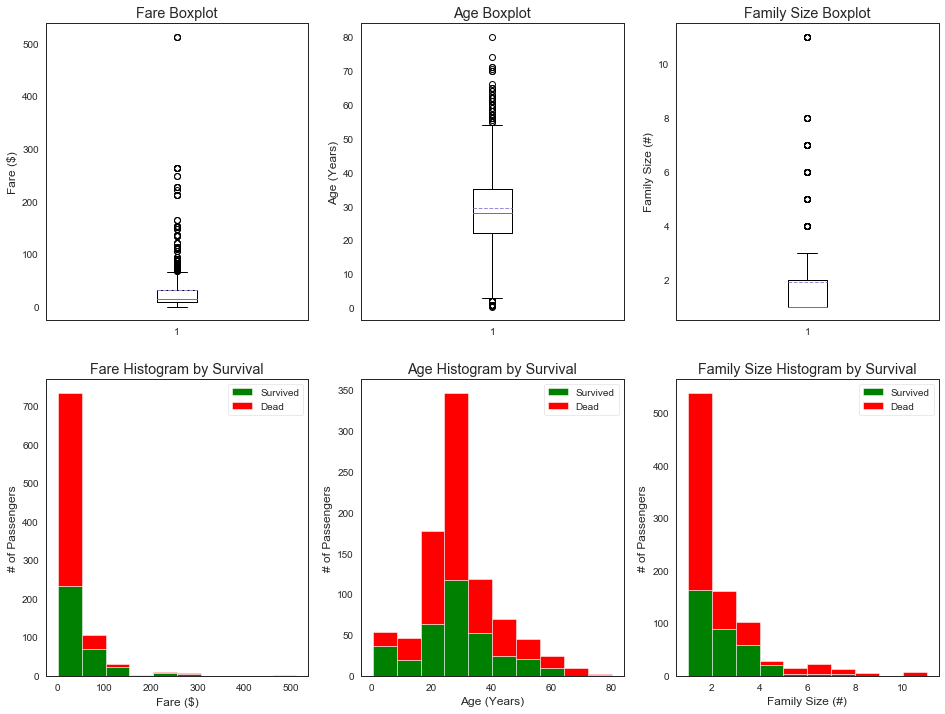

In [18]:
plt.figure(figsize=(16, 12))

# Fare 箱型图
plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

# Age 箱型图
plt.subplot(232)
plt.boxplot(data1['Age'], showmeans=True, meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

# FamilySize 箱型图
plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans=True, meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

# 根据Survived分组画Fare，叠加柱状图
plt.subplot(234)
plt.hist(x=[data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, # 叠加
         color=['g', 'r'],
         label=['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

# 根据Survived分组画Age，叠加柱状图
plt.subplot(235)
plt.hist(x=[data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, # 叠加
         color=['g', 'r'],
         label=['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

# 根据Survived分组画FamilySize，叠加柱状图
plt.subplot(236)
plt.hist(x=[data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, # 叠加
         color=['g', 'r'],
         label=['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

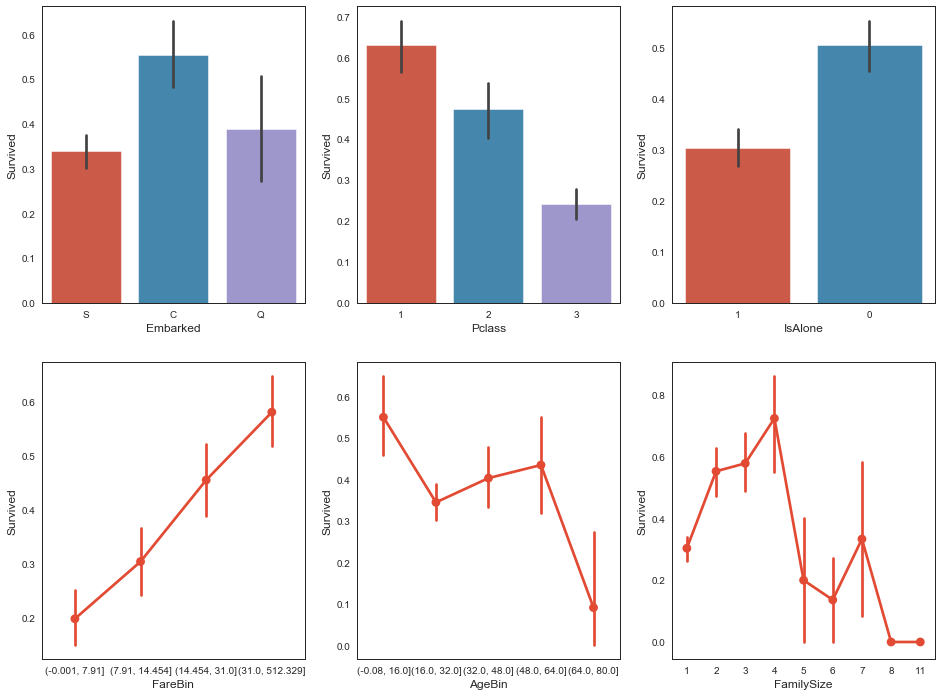

In [19]:
fig, saxis = plt.subplots(2, 3, figsize=(16, 12))

# 柱状图
sns.barplot(x='Embarked', y='Survived',
            data=data1,
            ax=saxis[0, 0])
sns.barplot(x='Pclass', y='Survived',
            data=data1,
            order=[1, 2, 3],
            ax=saxis[0, 1])
sns.barplot(x='IsAlone', y='Survived',
            data=data1,
            order=[1, 0],
            ax=saxis[0, 2])

# 折线图
sns.pointplot(x='FareBin', y='Survived',
              data=data1,
              ax=saxis[1, 0])
sns.pointplot(x='AgeBin', y='Survived',
              data=data1,
              ax=saxis[1, 1])
sns.pointplot(x='FamilySize', y='Survived',
              data=data1,
              ax=saxis[1, 2])

Text(0.5, 1.0, 'Pclass vs Family Size Survived Comparison')

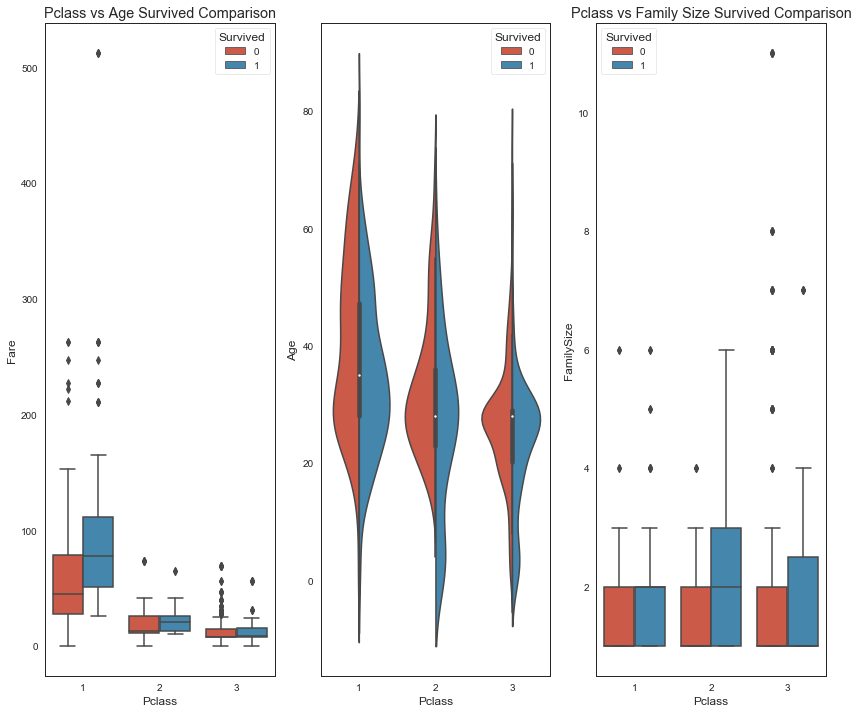

In [22]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(14, 12))

# 箱型图
sns.boxplot(x='Pclass', y='Fare',
            hue='Survived', # 额外分类
            data=data1,
            ax=axis1)
axis1.set_title('Pclass vs Fare Survived Comparison')

# 小提琴图
sns.violinplot(x='Pclass', y='Age',
            hue='Survived', # 额外分类
            data=data1,
            split=True,
            ax=axis2)
axis1.set_title('Pclass vs Age Survived Comparison')

# 箱型图
sns.boxplot(x='Pclass', y='FamilySize',
            hue='Survived', # 额外分类
            data=data1,
            ax=axis3)
axis3.set_title('Pclass vs Family Size Survived Comparison')

Text(0.5, 1.0, 'Sex vs IsAlone Survived Comparison')

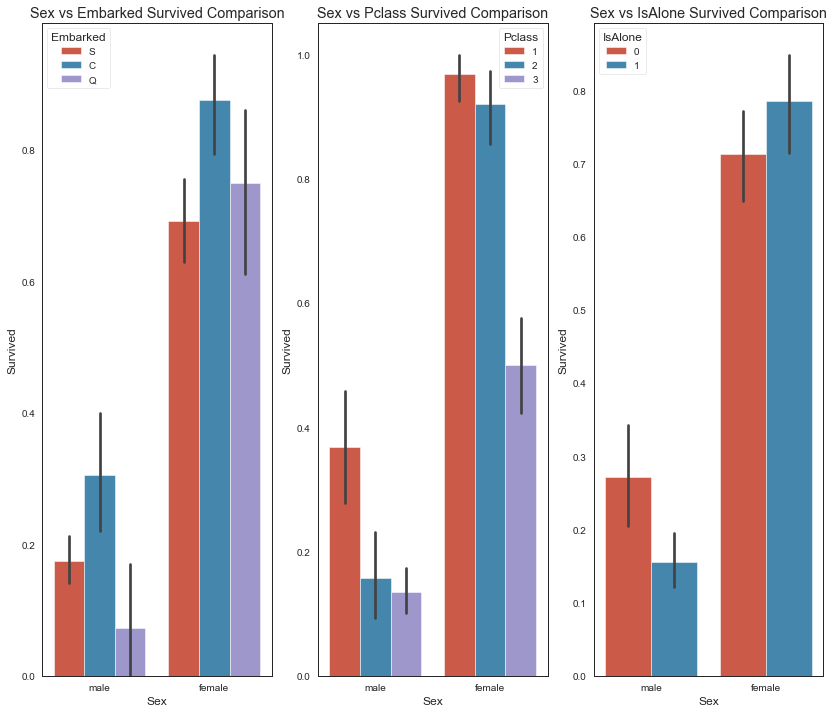

In [23]:
fig, qaxis = plt.subplots(1, 3, figsize=(14, 12))

# 柱状图
sns.barplot(x='Sex', y='Survived',
            hue='Embarked',
            data=data1,
            ax=qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survived Comparison')

sns.barplot(x='Sex', y='Survived',
            hue='Pclass',
            data=data1,
            ax=qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survived Comparison')

sns.barplot(x='Sex', y='Survived',
            hue='IsAlone',
            data=data1,
            ax=qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survived Comparison')

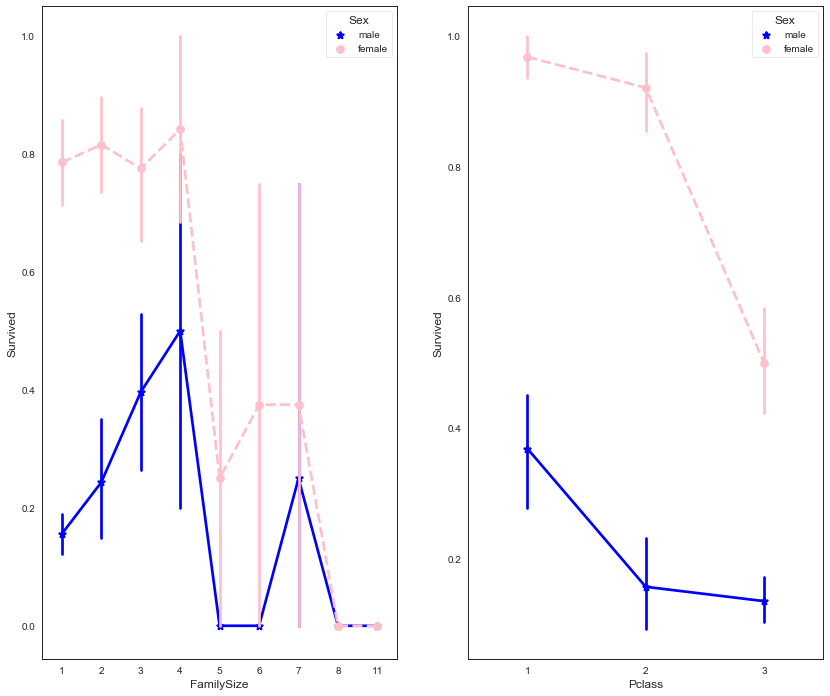

In [24]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize=(14, 12))

# 折线图
sns.pointplot(x='FamilySize', y='Survived',
              hue='Sex',
              data=data1,
              palette={'male': 'blue', 'female': 'pink'},
              markers=['*', 'o'],
              linestyles=['-', '--'],
              ax=maxis1)

# 折线图
sns.pointplot(x='Pclass', y='Survived',
              hue='Sex',
              data=data1,
              palette={'male': 'blue', 'female': 'pink'},
              markers=['*', 'o'],
              linestyles=['-', '--'],
              ax=maxis2)

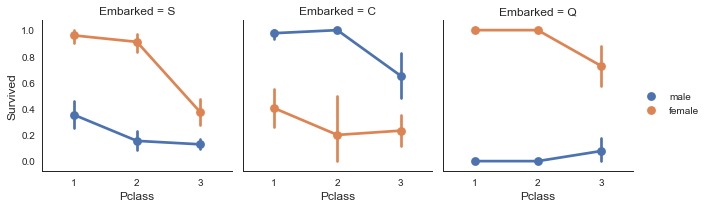

In [25]:
e = sns.FacetGrid(data1,
                  col='Embarked') # 分列
e.map(sns.pointplot,
      'Pclass', 'Survived',
      'Sex', # 额外分组
      ci=95.0,
      palette='deep')
e.add_legend()

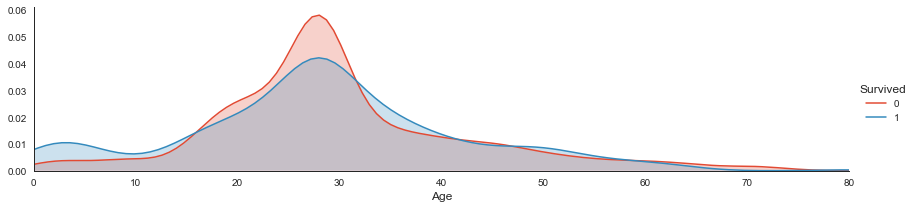

In [26]:
a = sns.FacetGrid(data1,
                  hue='Survived',
                  aspect=4)
a.map(sns.kdeplot,
      'Age', shade=True)
a.set(xlim=(0, data1['Age'].max()))
a.add_legend()

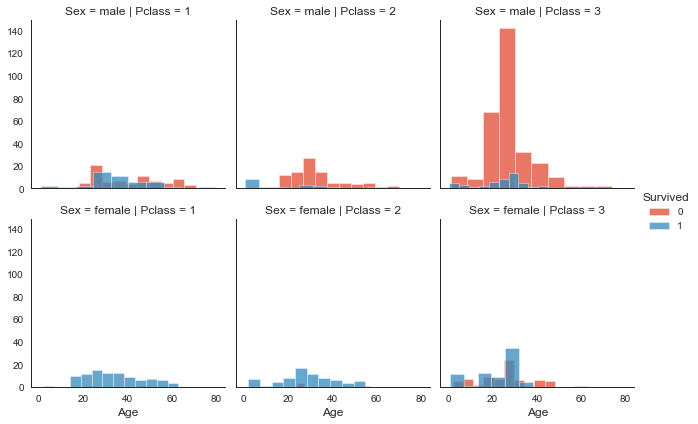

In [27]:
h = sns.FacetGrid(data1,
                  row='Sex', # 分行
                  col='Pclass', # 分列
                  hue='Survived') # 额外分组
h.map(plt.hist, 'Age', alpha=0.75)
h.add_legend()

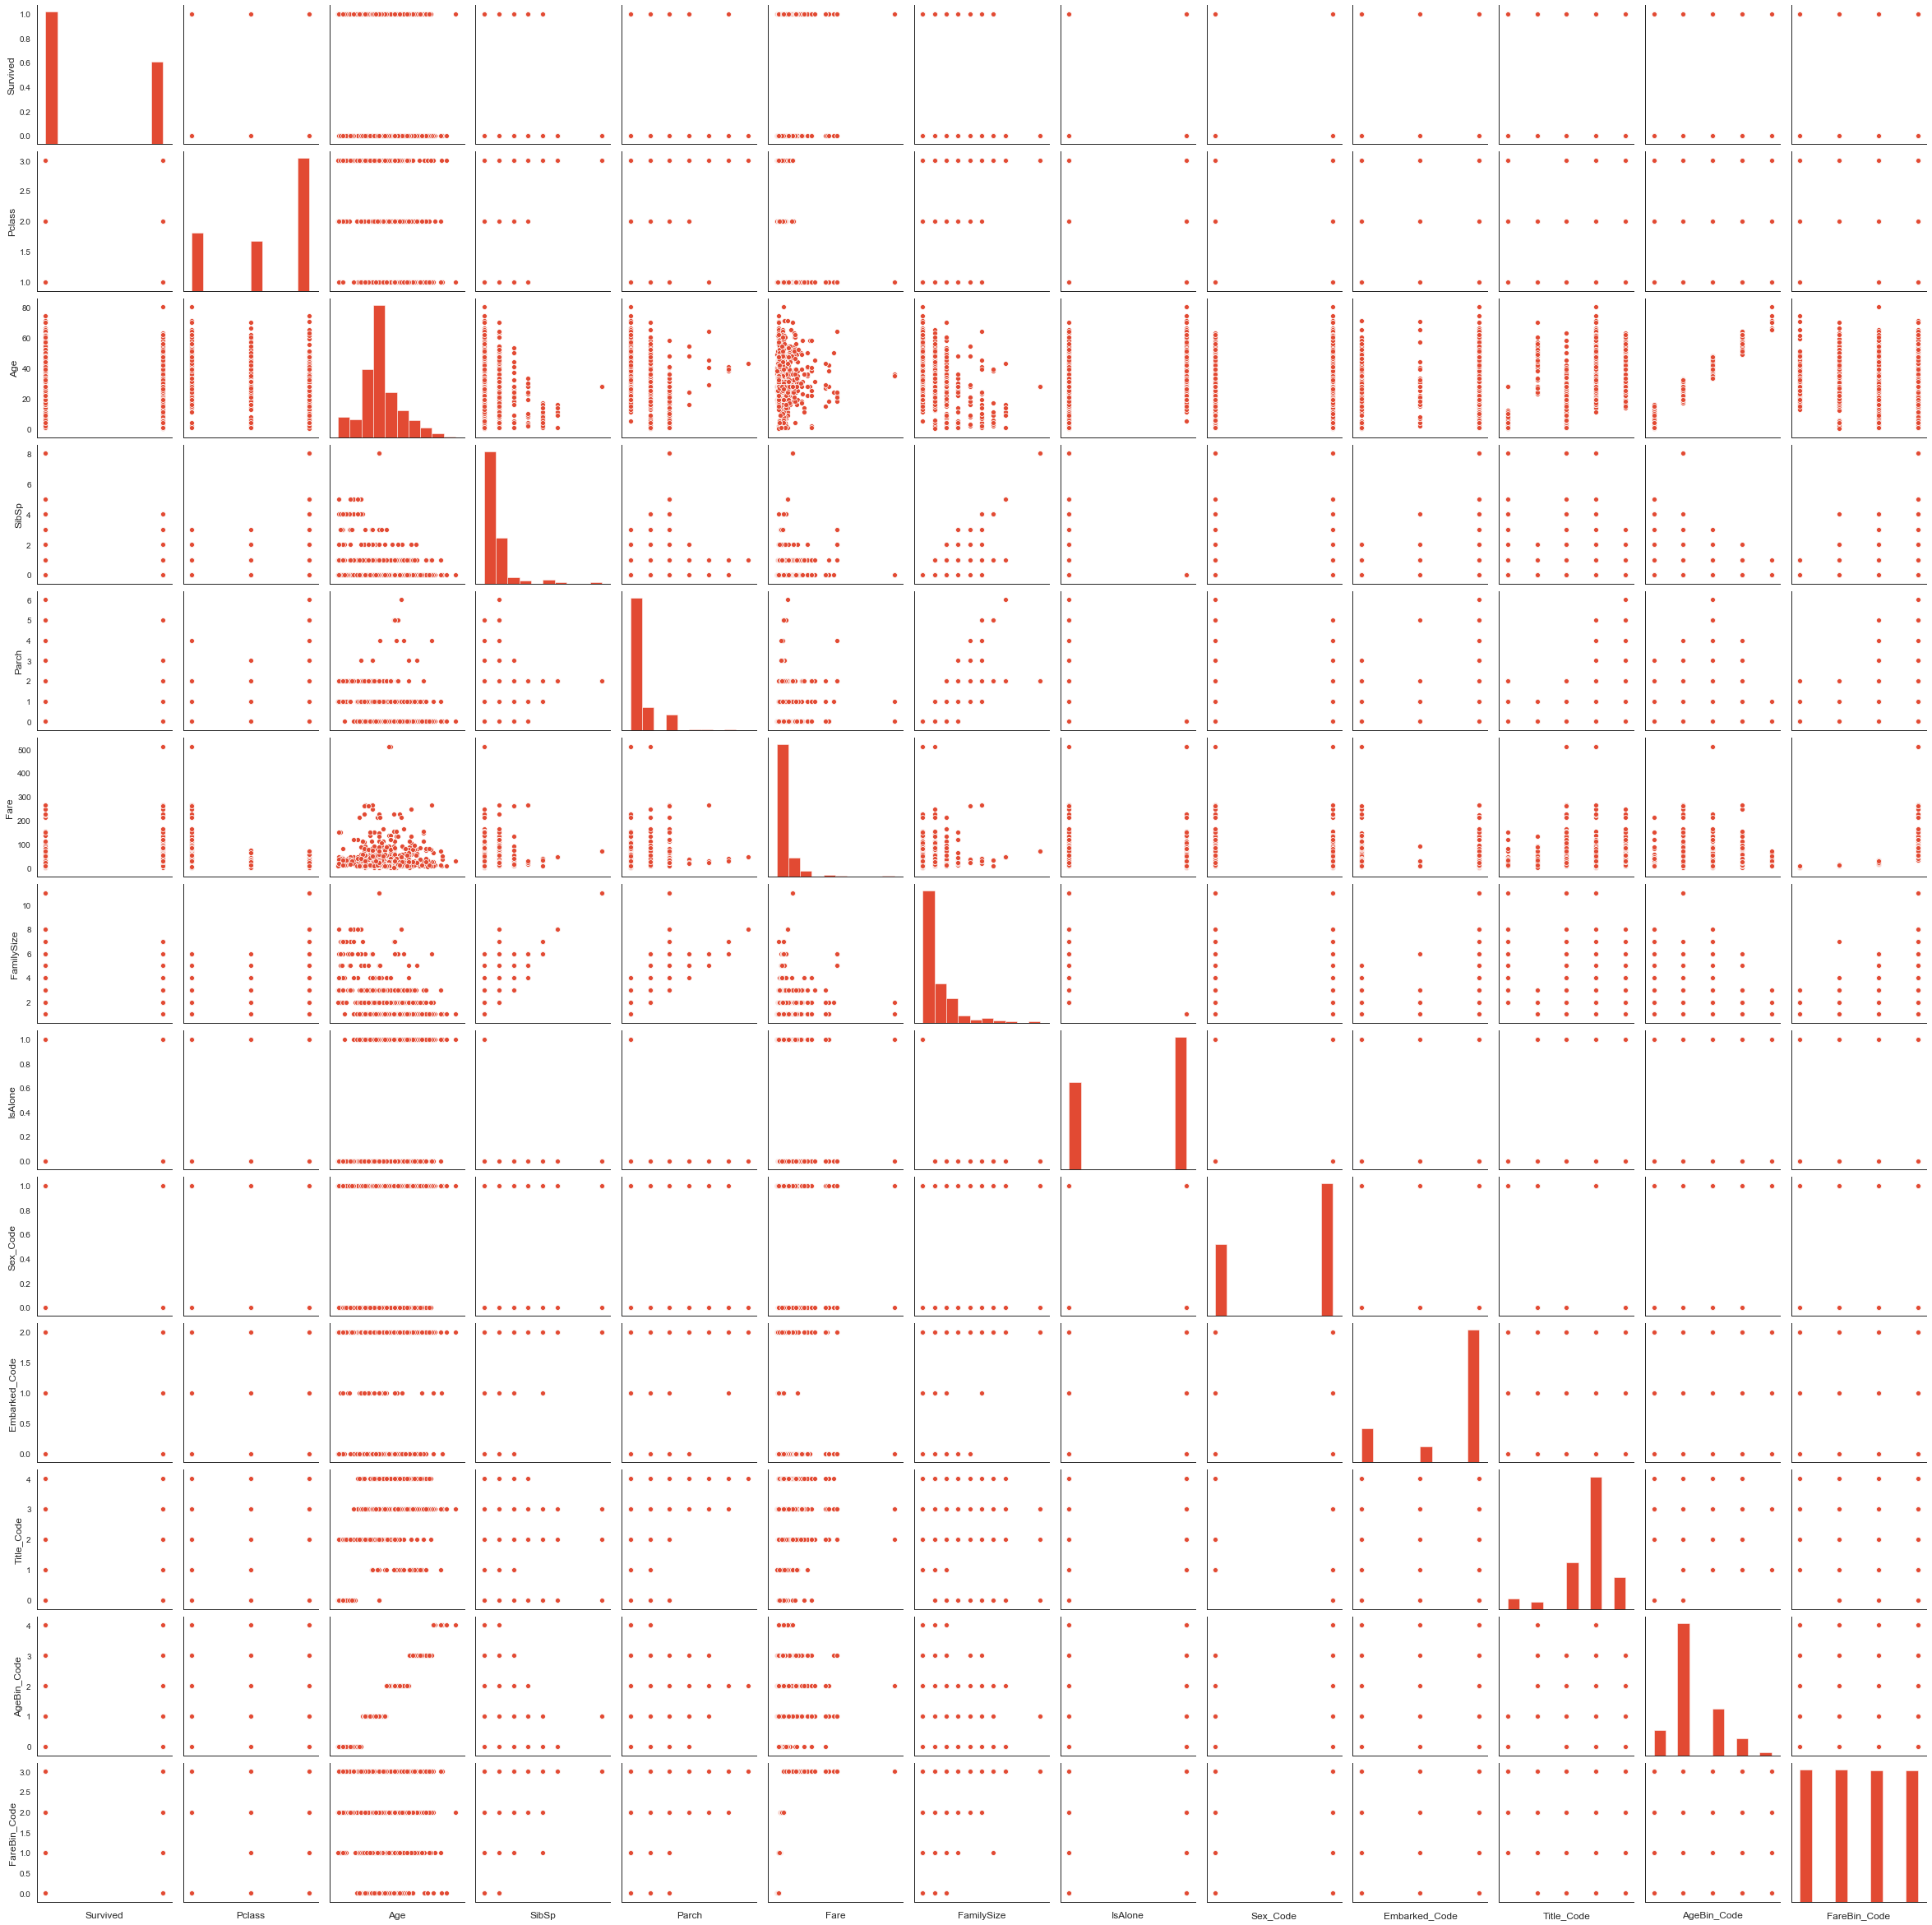

In [35]:
pp = sns.pairplot(data1)
pp.set(xticklabels=[])

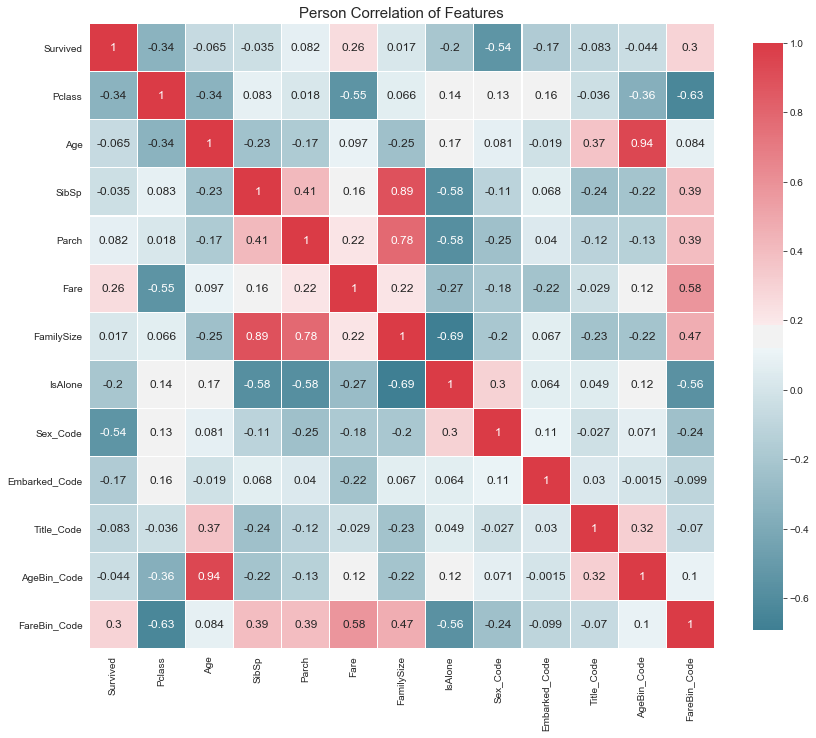

In [36]:
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    
    _ = sns.heatmap(df.corr(),
                    cmap=colormap,
                    square=True,
                    cbar_kws={'shrink': 0.9},
                    ax=ax,
                    annot=True,
                    linewidths=0.1,
                    vmax=1.0,
                    linecolor='white',
                    annot_kws={'fontsize': 12})
    
    plt.title('Person Correlation of Features', y=1.05, size=15)
    
correlation_heatmap(data1)

## Model Data